# <center> Prédiction de Volatilité <center/>
---
---

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.special as scsp
from tqdm.notebook import tqdm
plt.style.use("ggplot")

In [2]:
# Import de nos drive pour les fichiers
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
# 1 - Modèle

# 1.1 - Volatilité rugueuse

- Cette partie est une adaptation Python 3 du code du lien suivant : https://tpq.io/p/rough_volatility_with_python.html

In [3]:
data = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks Centrale/Deep Learning in Finance/TP5_PredVol/oxfordmanrealizedvolatilityindices.parquet")
# data.set_index("index", inplace=True)

# data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks Centrale/Deep Learning in Finance/TP5_PredVol/oxfordmanrealizedvolatilityindices.csv.gz", index_col=0, parse_dates=True)
# # data.set_index("index", inplace=True)
# data
data

,Symbol,close_price,open_to_close,medrv,rsv,rv5,rv10_ss,rv5_ss,bv_ss,rk_twoscale,open_price,bv,open_time,rv10,rk_parzen,close_time,rk_th2,rsv_ss,nobs
2000-01-03 00:00:00+00:00,.AEX,675.44,-0.000340,0.000050,0.000046,0.000130,0.000178,0.000130,0.000100,0.000103,675.67,0.000100,90101.0,0.000178,0.000179,163015.0,0.000102,0.000046,1795.0
2000-01-04 00:00:00+00:00,.AEX,642.25,-0.033606,0.000075,0.000147,0.000201,0.000261,0.000201,0.000207,0.000199,664.20,0.000207,90416.0,0.000261,0.000423,163016.0,0.000201,0.000147,1785.0
2000-01-05 00:00:00+00:00,.AEX,632.31,-0.001675,0.000166,0.000328,0.000491,0.000714,0.000491,0.000361,0.000325,633.37,0.000361,90016.0,0.000714,0.000324,163016.0,0.000345,0.000328,1801.0
2000-01-06 00:00:00+00:00,.AEX,624.21,-0.013130,0.000152,0.000116,0.000225,0.000182,0.000225,0.000258,0.000218,632.46,0.000258,90016.0,0.000182,0.000219,163002.0,0.000221,0.000116,1799.0
2000-01-07 00:00:00+00:00,.AEX,644.86,0.025013,0.000039,0.000048,0.000138,0.000157,0.000138,0.000130,0.000126,628.93,0.000130,90046.0,0.000157,0.000155,163016.0,0.000123,0.000048,1798.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11 00:00:00+00:00,.STOXX50E,3668.43,0.003848,0.000013,0.000014,0.000028,0.000021,0.000028,0.000027,0.000032,3654.34,0.000027,90015.0,0.000021,0.000009,173015.0,0.000033,0.000014,4255.0
2021-02-12 00:00:00+00:00,.STOXX50E,3695.01,0.007053,0.000014,0.000014,0.000031,0.000036,0.000031,0.000032,0.000031,3669.04,0.000032,90015.0,0.000036,0.000026,173002.0,0.000032,0.000014,4157.0
2021-02-15 00:00:00+00:00,.STOXX50E,3738.69,0.007340,0.000008,0.000006,0.000024,0.000021,0.000024,0.000021,0.000020,3711.35,0.000021,90015.0,0.000021,0.000016,173001.0,0.000021,0.000006,4236.0
2021-02-16 00:00:00+00:00,.STOXX50E,3725.56,-0.002673,0.000012,0.000013,0.000026,0.000026,0.000026,0.000026,0.000028,3735.53,0.000026,90015.0,0.000026,0.000010,173002.0,0.000028,0.000013,4224.0


- Avec les différentes valeurs :
  - bv :	Bipower Variation (5-min)
  - bv_ss :	Bipower Variation (5-min Sub-sampled)
  - close_price :	Closing (Last) Price
  - close_time :	Closing Time
  - medrv	: Median Realized Variance (5-min)
  - nobs	: Number of Observations
  - open_price : Opening (First) Price
  - open_time	: Opening Time
  - open_to_close	: Open to Close Return
  - rk_parzen	: Realized Kernel Variance (Non-Flat Parzen)
  - rk_th2 : Realized Kernel Variance (Tukey-Hanning(2))
  - rk_twoscale	: Realized Kernel Variance (Two-Scale/Bartlett)
  - rsv	: Realized Semi-variance (5-min)
  - rsv_ss	: Realized Semi-variance (5-min Sub-sampled)
  - rv10 : Realized Variance (10-min)
  - rv10_ss	: Realized Variance (10-min Sub-sampled)
  - rv5	: Realized Variance (5-min)
  - rv5_ss : Realized Variance (5-min Sub-sampled)

Avec $$Semivariance = \frac{1}{n}∑\limits^{n}_{r_t < Average}(Average - r_t)^{2}$$

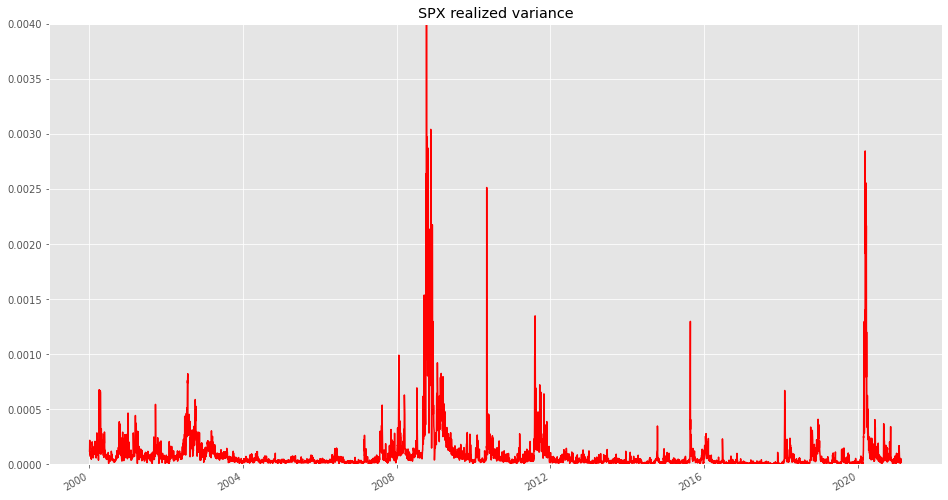

In [4]:
spx = data[data["Symbol"] == ".SPX"]
spx["rk_twoscale"].plot(color='red', grid=True, title='SPX realized variance',
         figsize=(16, 9), ylim=(0,0.004));

In [5]:
%%capture
spx['sqrt']= np.sqrt(spx['rk_twoscale'])
spx['log_sqrt'] = np.log(spx['sqrt'])

def del_Raw(q, x): 
    """ Scaling of m(q,Delta) avec lag Delta"""
    return [np.mean(np.abs(spx['log_sqrt'] - spx['log_sqrt'].shift(lag)) ** q) for lag in x]

[0.08495158289730485, 0.16930164043370957, 0.25320521325596695, 0.3368248767606616, 0.5034614329671553]


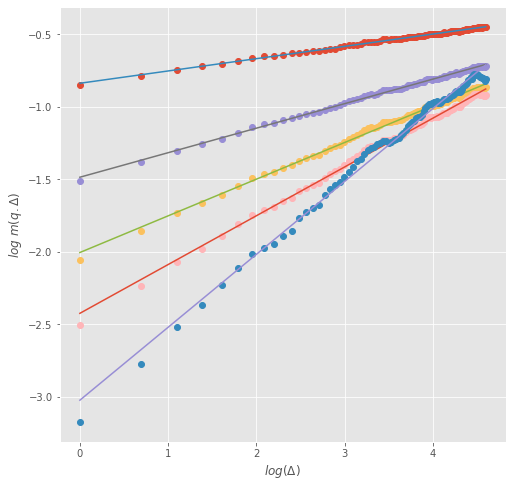

In [6]:
plt.figure(figsize=(8, 8))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o') 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1)
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])
    
print(zeta_q)

0.1679046908824655


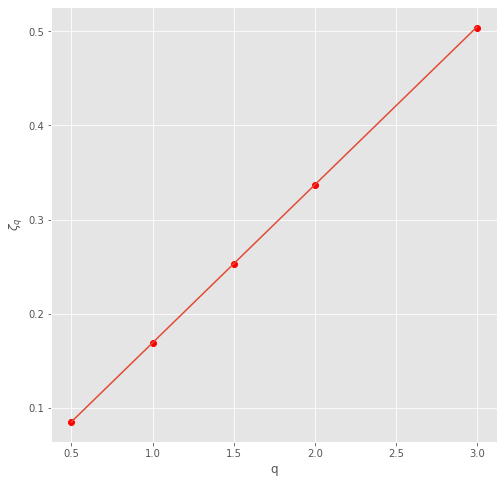

In [7]:
plt.figure(figsize=(8,8))
plt.xlabel('q')
plt.ylabel('$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1)
plt.plot(qVec, line[0] * qVec + line[1])
h_est= line[0]
print(h_est)

In [8]:
# Répéter l'analyse ci-dessus pour les différents indices du dataset
def dlsig2(sig, x, pr=False):
    if pr:
        a = np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a = a ** 2
        print(a.info())
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]

In [ ]:
h = list() # coeffs hurst
nu = list() # estimation de la variance

for mysymbol in data["Symbol"].unique():
    sig = data[data["Symbol"]==mysymbol]["rk_twoscale"]
    sig = np.log(np.sqrt(sig))
    sig = sig.dropna()
    model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
    nu.append(np.sqrt(np.exp(model[1])))
    h.append(model[0]/2.)
    
OxfordH = pd.DataFrame({'Symbol':data["Symbol"].unique(), 'h_est': h, 'nu_est': nu})

### Variances forecasts

In [11]:
import pdb

def c_tilde(h):
    return scsp.gamma(3. / 2. - h) / scsp.gamma(h + 1. / 2.) * scsp.gamma(2. - 2. * h)

def forecast_XTS(rvdata, h, date, nLags, delta, nu):
    i = np.arange(nLags)
    cf = 1./((i + 1. / 2.) ** (h + 1. / 2.) * (i + 1. / 2. + delta))
    ldata = pd.DataFrame(rvdata.truncate(after=date))

    l = len(ldata)
    ldata = np.log(ldata[l - nLags:])

    ldata['cf'] = np.fliplr([cf])[0]
    # print ldata
    ldata = ldata.dropna()
    fcst = (ldata.iloc[:, 0] * ldata['cf']).sum() / sum(ldata['cf'])    
    return math.exp(fcst + 2 * nu ** 2 * c_tilde(h) * delta ** (2 * h))

In [12]:
mysymbol=".SPX"

rvdata=data[data["Symbol"]==mysymbol]["rk_twoscale"]

In [13]:
fit_symbol = OxfordH[OxfordH["Symbol"]==mysymbol]
nu  = fit_symbol['nu_est'] # Vol of vol estimate for SPX
h = fit_symbol["h_est"].values
n = len(rvdata)
delta = 1
nLags = 5
dates = rvdata.iloc[nLags:n-delta].index

In [14]:
delta = 1
nLags = 500
dates = rvdata.iloc[nLags:n-delta].index
rv_predict = [forecast_XTS(rvdata, h=h, date=d, nLags=nLags,
                           delta=delta, nu=nu) for d in dates]
rv_actual = rvdata.iloc[nLags+delta:n].values

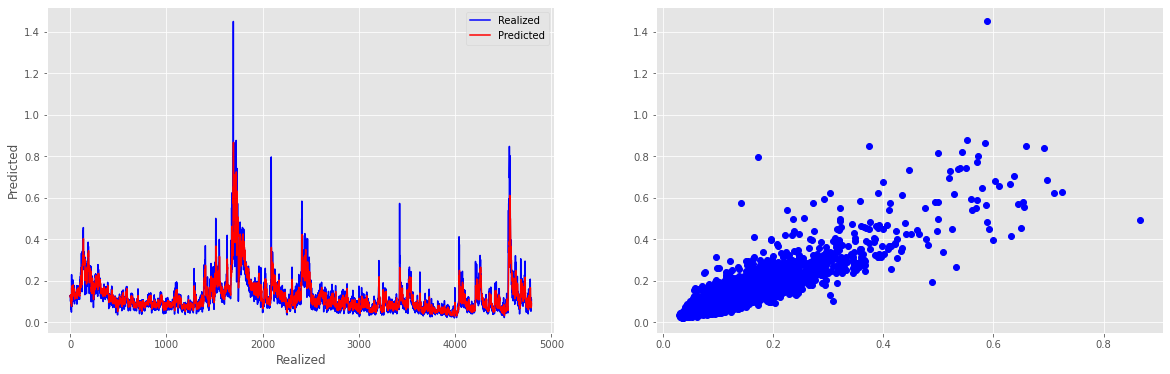

In [164]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].set(xlabel="Points", ylabel="Annualized vol")
ax[0].set(xlabel="Realized", ylabel="Predicted")
ax[0].plot(vol_actual, "b", label="Realized")
ax[0].plot(vol_predict, "r", label="Predicted");
ax[1].plot(vol_predict, vol_actual, 'bo');
ax[0].legend();

## On stocke les prévisions de vol dans un fichier pour une utilisation ultérieure

- Il est important de noter que ce n'est pas la vol annualisée qui est stockée mais la variance predite "rv_predict"

In [ ]:
pd.DataFrame(rv_predict).to_csv("/content/drive/MyDrive/Colab Notebooks Centrale/Deep Learning in Finance/TP5_PredVol/Predicted_vol_1.1.csv", index=False, header=False)

# 2 - Prévision par Deep Learning

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

# gpu_devices = tf.config.experimental.list_physical_devices('GPU')  # allow memory use to grow
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

In [21]:
from keras.models import Sequential,Model
from keras.layers import Input, Dense, LSTM, GRU, Activation, Reshape, Flatten, Dropout, Lambda, RepeatVector
from keras.layers import Add,Multiply
from keras.layers import BatchNormalization
from keras.layers import UpSampling1D, Conv1D
from keras.layers import LeakyReLU

In [22]:
spx

,Symbol,close_price,open_to_close,medrv,rsv,rv5,rv10_ss,rv5_ss,bv_ss,rk_twoscale,open_price,bv,open_time,rv10,rk_parzen,close_time,rk_th2,rsv_ss,nobs,sqrt,log_sqrt
2000-01-03 00:00:00+00:00,.SPX,1454.24,-0.011602,0.000058,0.000096,0.000141,0.000164,0.000141,0.000141,0.000122,1471.21,0.000141,83004.0,0.000164,0.000340,145959.0,0.000130,0.000096,1554.0,0.011033,-4.506843
2000-01-04 00:00:00+00:00,.SPX,1399.02,-0.035102,0.000067,0.000180,0.000224,0.000295,0.000224,0.000173,0.000142,1449.00,0.000173,83009.0,0.000295,0.000215,150000.0,0.000162,0.000180,1564.0,0.011930,-4.428714
2000-01-05 00:00:00+00:00,.SPX,1402.09,0.004625,0.000142,0.000131,0.000314,0.000267,0.000314,0.000303,0.000219,1395.62,0.000303,83012.0,0.000267,0.000163,150003.0,0.000240,0.000131,1552.0,0.014800,-4.213107
2000-01-06 00:00:00+00:00,.SPX,1403.06,0.002991,0.000070,0.000056,0.000131,0.000115,0.000131,0.000128,0.000127,1398.87,0.000128,83005.0,0.000115,0.000067,145954.0,0.000132,0.000056,1561.0,0.011251,-4.487290
2000-01-07 00:00:00+00:00,.SPX,1440.84,0.026293,0.000049,0.000023,0.000094,0.000121,0.000094,0.000079,0.000091,1403.45,0.000079,83000.0,0.000121,0.000215,150000.0,0.000095,0.000023,1540.0,0.009535,-4.652832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-10 00:00:00+00:00,.SPX,3910.02,-0.002748,0.000018,0.000050,0.000078,0.000054,0.000078,0.000077,0.000055,3920.78,0.000077,83001.0,0.000054,0.000065,150001.0,0.000053,0.000050,23401.0,0.007407,-4.905287
2021-02-11 00:00:00+00:00,.SPX,3916.28,-0.000031,0.000015,0.000026,0.000043,0.000042,0.000043,0.000033,0.000032,3916.40,0.000033,83001.0,0.000042,0.000033,150001.0,0.000031,0.000026,23401.0,0.005645,-5.177072
2021-02-12 00:00:00+00:00,.SPX,3935.07,0.005969,0.000007,0.000004,0.000015,0.000012,0.000015,0.000014,0.000013,3911.65,0.000014,83001.0,0.000012,0.000017,150001.0,0.000013,0.000004,23401.0,0.003573,-5.634475
2021-02-16 00:00:00+00:00,.SPX,3932.25,-0.001870,0.000016,0.000023,0.000042,0.000030,0.000042,0.000041,0.000032,3939.61,0.000041,83001.0,0.000030,0.000018,150000.0,0.000032,0.000023,23400.0,0.005690,-5.168998


- Fonctions permettant de transformer nos features en matrice 3D d'input du LSTM.

In [23]:
#split a univariate sequence into samples
def split_sequence_univariate(sequence, n_steps):
    """ Pour transformer un array 1D en 3D"""
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


# def split_sequences_multivariate(sequences, n_steps):
#     """ Pour transformer un array 2D en 3D"""
#     X, y = list(), list()
#     for i in range(len(sequences)):
# # find the end of this pattern
#         end_ix = i + n_steps
# # check if we are beyond the dataset
#         if end_ix > len(sequences)-1:
#             break
# # gather input and output parts of the pattern
#         seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, -1]
#         X.append(seq_x)
#         y.append(seq_y)
#     return np.array(X), np.array(y)

## 1) Matrice de prédicteurs sans prévision de vol issue de modèles

- Nous allons estimer le log de la variance, comme dans la partie précédente. 

In [121]:
X_full_log = np.log(spx[["rk_twoscale"]].values)  

- On utilise la fonction permettant d'avoir notre dataset en format 3D d'input pour le LSTM.

In [122]:
N_I = 100 # Longueur de la séquence d'input du LSTM
X_sample,y_sample=split_sequence_univariate(X_full_log, N_I) 
pd.DataFrame(X_sample.reshape(X_sample.shape[0], X_sample.shape[1]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-9.013685,-8.857427,-8.426213,-8.974581,-9.305664,-9.155427,-9.535343,-9.109009,-9.358711,-9.422623,-9.537633,-9.904076,-9.147005,-9.904493,-8.922844,-8.859772,-9.502663,-8.915450,-8.491714,-8.681621,-9.033426,-8.817958,-8.953030,-9.635946,-9.621037,-9.712135,-9.197438,-9.093327,-9.217012,-9.303124,-9.132378,-9.216386,-8.721937,-8.931130,-8.771781,-9.055697,-8.470310,-8.665389,-8.618127,-9.210345,...,-8.454897,-8.541160,-8.376927,-7.295877,-7.725891,-8.622939,-9.203708,-9.024197,-8.374678,-9.011034,-8.145206,-7.306642,-7.334833,-8.223146,-8.534250,-9.282389,-8.036063,-8.908287,-9.008127,-8.175250,-9.142083,-9.049544,-8.943677,-8.651940,-8.845353,-8.985020,-9.046932,-8.860779,-8.404084,-8.985739,-9.412004,-9.362600,-8.518716,-8.951772,-9.656680,-8.999254,-8.194818,-8.555588,-8.130511,-8.649147
1,-8.857427,-8.426213,-8.974581,-9.305664,-9.155427,-9.535343,-9.109009,-9.358711,-9.422623,-9.537633,-9.904076,-9.147005,-9.904493,-8.922844,-8.859772,-9.502663,-8.915450,-8.491714,-8.681621,-9.033426,-8.817958,-8.953030,-9.635946,-9.621037,-9.712135,-9.197438,-9.093327,-9.217012,-9.303124,-9.132378,-9.216386,-8.721937,-8.931130,-8.771781,-9.055697,-8.470310,-8.665389,-8.618127,-9.210345,-9.190616,...,-8.541160,-8.376927,-7.295877,-7.725891,-8.622939,-9.203708,-9.024197,-8.374678,-9.011034,-8.145206,-7.306642,-7.334833,-8.223146,-8.534250,-9.282389,-8.036063,-8.908287,-9.008127,-8.175250,-9.142083,-9.049544,-8.943677,-8.651940,-8.845353,-8.985020,-9.046932,-8.860779,-8.404084,-8.985739,-9.412004,-9.362600,-8.518716,-8.951772,-9.656680,-8.999254,-8.194818,-8.555588,-8.130511,-8.649147,-8.798241
2,-8.426213,-8.974581,-9.305664,-9.155427,-9.535343,-9.109009,-9.358711,-9.422623,-9.537633,-9.904076,-9.147005,-9.904493,-8.922844,-8.859772,-9.502663,-8.915450,-8.491714,-8.681621,-9.033426,-8.817958,-8.953030,-9.635946,-9.621037,-9.712135,-9.197438,-9.093327,-9.217012,-9.303124,-9.132378,-9.216386,-8.721937,-8.931130,-8.771781,-9.055697,-8.470310,-8.665389,-8.618127,-9.210345,-9.190616,-9.340817,...,-8.376927,-7.295877,-7.725891,-8.622939,-9.203708,-9.024197,-8.374678,-9.011034,-8.145206,-7.306642,-7.334833,-8.223146,-8.534250,-9.282389,-8.036063,-8.908287,-9.008127,-8.175250,-9.142083,-9.049544,-8.943677,-8.651940,-8.845353,-8.985020,-9.046932,-8.860779,-8.404084,-8.985739,-9.412004,-9.362600,-8.518716,-8.951772,-9.656680,-8.999254,-8.194818,-8.555588,-8.130511,-8.649147,-8.798241,-9.308414
3,-8.974581,-9.305664,-9.155427,-9.535343,-9.109009,-9.358711,-9.422623,-9.537633,-9.904076,-9.147005,-9.904493,-8.922844,-8.859772,-9.502663,-8.915450,-8.491714,-8.681621,-9.033426,-8.817958,-8.953030,-9.635946,-9.621037,-9.712135,-9.197438,-9.093327,-9.217012,-9.303124,-9.132378,-9.216386,-8.721937,-8.931130,-8.771781,-9.055697,-8.470310,-8.665389,-8.618127,-9.210345,-9.190616,-9.340817,-9.554475,...,-7.295877,-7.725891,-8.622939,-9.203708,-9.024197,-8.374678,-9.011034,-8.145206,-7.306642,-7.334833,-8.223146,-8.534250,-9.282389,-8.036063,-8.908287,-9.008127,-8.175250,-9.142083,-9.049544,-8.943677,-8.651940,-8.845353,-8.985020,-9.046932,-8.860779,-8.404084,-8.985739,-9.412004,-9.362600,-8.518716,-8.951772,-9.656680,-8.999254,-8.194818,-8.555588,-8.130511,-8.649147,-8.798241,-9.308414,-8.968436
4,-9.305664,-9.155427,-9.535343,-9.109009,-9.358711,-9.422623,-9.537633,-9.904076,-9.147005,-9.904493,-8.922844,-8.859772,-9.502663,-8.915450,-8.491714,-8.681621,-9.033426,-8.817958,-8.953030,-9.635946,-9.621037,-9.712135,-9.197438,-9.093327,-9.217012,-9.303124,-9.132378,-9.216386,-8.721937,-8.931130,-8.771781,-9.055697,-8.470310,-8.665389,-8.618127,-9.210345,-9.190616,-9.340817,-9.554475,-9.739613,...,-7.725891,-8.622939,-9.203708,-9.024197,-8.374678,-9.011034,-8.145206,-7.306642,-7.334833,-8.223146,-8.534250,-9.282389,-8.036063,-8.90

## 2) LSTM pour la prévision

- Voici les paramètres : 
  - T_in : Longueur des données dans la fenêtre train
  - dT : Nombre de points entre calibration (nombre de points prédit par le réseau après chaque entrainement)
  - t1s : Vecteur des pas de temps de fin de fenetre de calibration 
  - On utilise stateful LSTM (qui ne reset pas l'état caché entre deux échantillons)
    - Par défaut le LSTM de keras reset l'état du réseau (state) après chaque batch size
    - On utilise donc stateful pour garder l'état caché pour les batchs d'après.

- Une fois qu'on a entrainé le modèle, il va falloir prédire sur la partie d'après (de t1 à t1+dT), puis le principe est le même pour chaque itération.

In [123]:
def pred_LSTM(neurons_lstm, batch_size, X_sample_shape):
  """ Retourne un modèle juste compilé"""
  model = Sequential()
  # model.add(LSTM(neurons_lstm, input_shape=(X_sample_shape[1], X_sample_shape[2]), stateful=True))
  model.add(LSTM(neurons_lstm, batch_input_shape=(batch_size, X_sample_shape[1], X_sample_shape[2]), stateful=True))
  # On rajoute la couche de sortie
  model.add(Dense(units=1)) # on ne précise pas l'activation, donc ca va être "linéaire" par défaut. 
  # On compile 
  model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])
  return model

In [124]:
# Nos paramètres
batch_size=64
neurons_lstm = 100
num_epochs = 20
T_in = batch_size*20 
dT = 100  

In [ ]:
import warnings; warnings.simplefilter('ignore')

t1s=np.arange(T_in,X_sample.shape[0]-T_in,dT) ### Nous on doit faire une boucle ou on entraine N fois notre réseau de neurones de facon mobile
myLSTM = pred_LSTM(neurons_lstm, batch_size, X_sample.shape)   # define a function that returns a model  ### Il faut définir cette fonction
predstot2 = np.array([])

for t1 in tqdm(t1s):
  t0 = t1 - T_in
  myLSTM.fit(X_sample[t0:t1], y_sample[t0:t1], batch_size = batch_size, validation_split = 0.2, epochs=num_epochs)
  myLSTM_1 = pred_LSTM(neurons_lstm, dT, X_sample.shape)
  # on utilise set_weights car la taille du batch size est différent (dT=100 pour la prédiction)
  myLSTM_1.set_weights(myLSTM.get_weights())
  preds = myLSTM_1.predict(X_sample[t1:t1+dT],batch_size=dT).flatten()

  # On concatene toutes les predictions
  predstot2 = np.concatenate((predstot2, preds))

- On revient reprend la variance normale avec l'exponentielle, puis on l'annualise pour pouvoir comparer

In [126]:
# On revient a la variance normale avec l'exp
X_full_2 = np.exp(X_full_log)[N_I + t1s[0]:t1s[-1]+N_I+dT] # la prédiction commence à partir de la 1380ème donnée (100 timesteps + 1280 premier entrainement)
predstot2 = np.exp(predstot2)

In [127]:
# On annualise
X_full_2 = np.sqrt(X_full_2*252)
predstot2 = np.sqrt(predstot2*252)

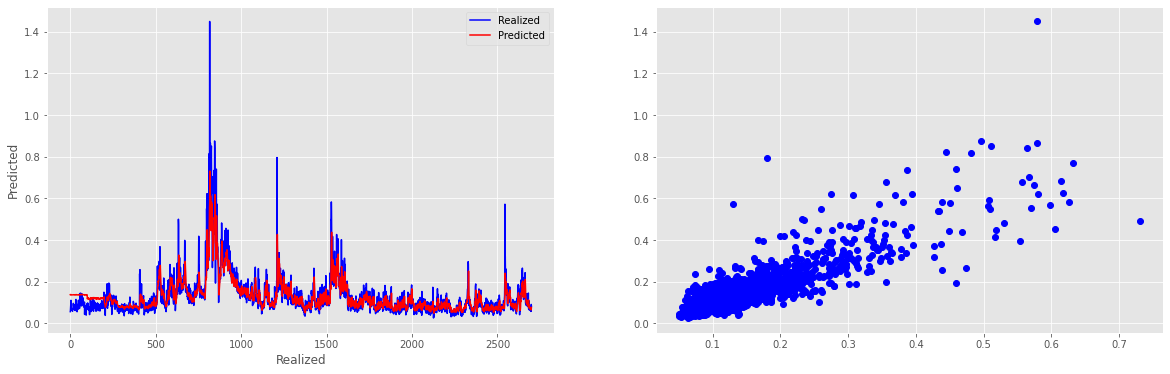

In [128]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].set(xlabel="Points", ylabel="Annualized vol")
ax[0].set(xlabel="Realized", ylabel="Predicted")
ax[0].plot(X_full_2, "b", label="Realized")
ax[0].plot(predstot2, "r", label="Predicted");
ax[1].plot(predstot2, X_full_2, 'bo');
ax[0].legend();

- On voit donc que les pics de vols ne sont pas bien prédit.

  - En fait, on ne parvient pas à prédire la bonne amplitude des pics car le réseau ne peut pas prédire ce qu'il ne connait pas. En effet, sur les précédentes valeurs, aucun pic d'une telle amplitude n'est observé.

  - Afin de prédire correctement ces valeurs extremes de volatilité, il faudrait des pics plus fréquents, ce qui pose le problème de la taille de la fenêtre. Mais plus on entraine le réseau sur une longue période, plus on rencontre de valeurs extremes ce qui permettra de mieux estimer l'amplitude des pics. 



In [129]:
# On stocke les dernières prévisions
pd.DataFrame(predstot2).to_csv("/content/drive/MyDrive/Colab Notebooks Centrale/Deep Learning in Finance/TP5_PredVol/Predicted_vol_2.csv", index=False, header=False)

---
# 3 - DL + Modèle

## 1) Ajout de la volatilité prédite en partie 1.1

- Ici nous allons rajouter la prévisibilité stockée durant la partie 1.1 dans notre matrice de predicteur.
- On note qu'on doit enlever les 501 premieres valeurs de nos variances réalisées car les vols prédites (rv_predict) ne les contiennent pas.
- Nous utilisons ensuite la même architecture afin d'estimer la volatilité. 

In [176]:
X_full_log = np.log(spx[["rk_twoscale"]][501:].values)
rv_predict_log = np.log(pd.read_csv("/content/drive/MyDrive/Colab Notebooks Centrale/Deep Learning in Finance/TP5_PredVol/Predicted_vol_1.1.csv", header=None).values)

In [177]:
N_I = 100 # length of sequences input to LSTMs (peut etre a changer))
X_full_log_sample, y_sample = split_sequence_univariate(X_full_log, N_I)
rv_predict_log_sample, _ = split_sequence_univariate(rv_predict_log, N_I)
# On concatene de sorte a avoir la deuxieme feature en profondeur (cube)
X_sample = np.concatenate((X_full_log_sample, rv_predict_log_sample), axis=2)
X_sample.shape

(4694, 100, 2)

- On refait tourner de la même manière que la question précédente, en gardant les mêmes paramètres

In [ ]:
# Nos paramètres
batch_size=64
neurons_lstm = 100
num_epochs = 20
T_in = batch_size*20 
dT = 100

t1s=np.arange(T_in,X_sample.shape[0]-T_in,dT) 
myLSTM = pred_LSTM(neurons_lstm, batch_size, X_sample.shape) 
predstot3 = np.array([])

for t1 in tqdm(t1s):
  t0 = t1 - T_in
  myLSTM.fit(X_sample[t0:t1], y_sample[t0:t1], batch_size = batch_size, validation_split = 0.2, epochs=num_epochs)
  myLSTM_1 = pred_LSTM(neurons_lstm, dT, X_sample.shape)
  myLSTM_1.set_weights(myLSTM.get_weights())
  preds = myLSTM_1.predict(X_sample[t1:t1+dT],batch_size=dT).flatten()

  # On concatene toutes les predictions
  predstot3 = np.concatenate((predstot3, preds))

In [179]:
# On revient a la variance normale avec l'exp
X_full_3 = np.exp(X_full_log)[N_I + t1s[0]:t1s[-1]+N_I+dT]
predstot3 = np.exp(predstot3)

In [180]:
# On annualise
X_full_3 = np.sqrt(X_full_3*252)
predstot3 = np.sqrt(predstot3*252)

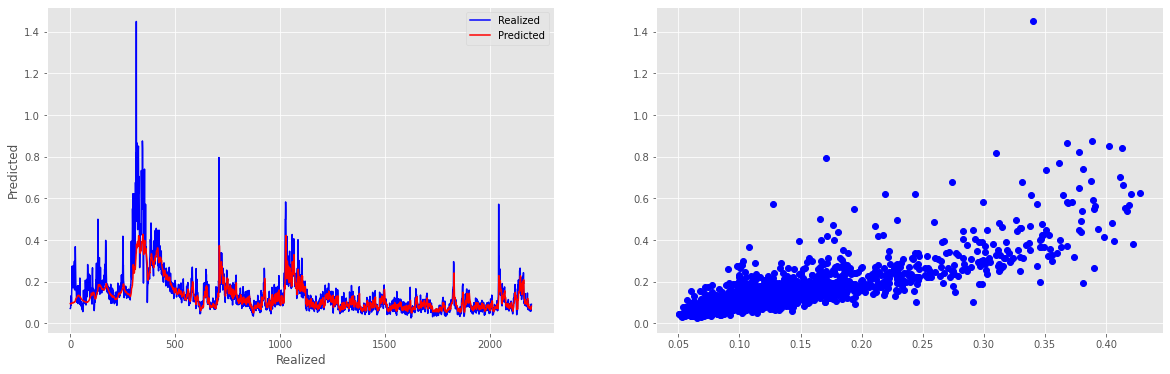

In [181]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].set(xlabel="Points", ylabel="Annualized vol")
ax[0].set(xlabel="Realized", ylabel="Predicted")
ax[0].plot(X_full_3, "b", label="Realized")
ax[0].plot(predstot3, "r", label="Predicted");
ax[1].plot(predstot3, X_full_3, 'bo');
ax[0].legend();

- On voit que pour les premiers pics le pouvoir prédictif est extremement faible, mais que les pics suivants sont mieux estimés (celui aux alentours de 1000 par exemple)
- On note que nous avons moins de données ici,
  - c'est du au fait que le fichier de vol_prédite du modèle rough ne contient pas les 501 premières valeurs, et que nos premières prédictions via le LSTM sont effectuées à partir de la 1380ème donnée (1280 taille de la fenêtre de calibration d'entrainement et 100 timesteps)
  - le réseau ne peut dons pas autant apprendre que dans le cas précédent. 

## 2) Autre possibilité : faire apprendre les résidus $\log(\sigma_{realized}) - \log(\sigma_{rough})$ au LSTM

- Nous allons ici utiliser comme deuxième feature non pas les vols prédites mais les résidus.

In [182]:
X_full_log = np.log(spx[["rk_twoscale"]][501:].values)
rv_predict_log = np.log(pd.read_csv("/content/drive/MyDrive/Colab Notebooks Centrale/Deep Learning in Finance/TP5_PredVol/Predicted_vol_1.1.csv", header=None).values)

resids = X_full_log - rv_predict_log

In [183]:
N_I = 100 
X_full_log_sample, y_sample = split_sequence_univariate(X_full_log, N_I)
resids_sample, _ = split_sequence_univariate(resids, N_I)
# On concatene de sorte a avoir la deuxieme feature en profondeur (cube)
X_sample = np.concatenate((X_full_log_sample, resids_sample), axis=2)
X_sample.shape

(4694, 100, 2)

- On refait tourner de la même manière que la question précédente, en gardant les mêmes paramètres

In [ ]:
# Nos paramètres
batch_size=64
neurons_lstm = 100
num_epochs = 20
T_in = batch_size*20 
dT = 100

t1s=np.arange(T_in,X_sample.shape[0]-T_in,dT) 
myLSTM = pred_LSTM(neurons_lstm, batch_size, X_sample.shape) 
predstot3_2 = np.array([])

for t1 in tqdm(t1s):
  t0 = t1 - T_in
  myLSTM.fit(X_sample[t0:t1], y_sample[t0:t1], batch_size = batch_size, validation_split = 0.2, epochs=num_epochs)
  myLSTM_1 = pred_LSTM(neurons_lstm, dT, X_sample.shape)
  myLSTM_1.set_weights(myLSTM.get_weights())
  preds = myLSTM_1.predict(X_sample[t1:t1+dT],batch_size=dT).flatten()

  # On concatene toutes les predictions
  predstot3_2 = np.concatenate((predstot3_2, preds))

In [185]:
# On revient a la variance avec le exp pour pouvoi
X_full_3_2 = np.exp(X_full_log)[N_I + t1s[0]:t1s[-1]+N_I+dT]
predstot3_2 = np.exp(predstot3_2)

In [186]:
# On annualise
X_full_3_2 = np.sqrt(X_full_3_2*252)
predstot3_2 = np.sqrt(predstot3_2*252)

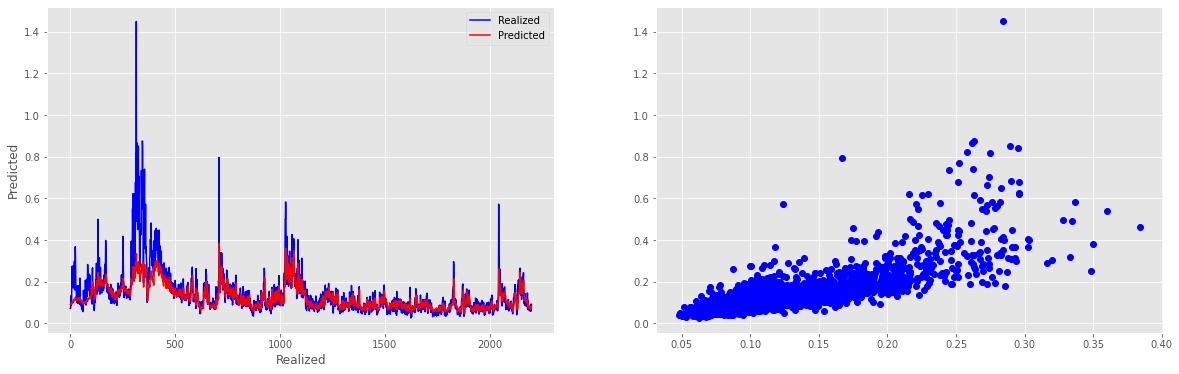

In [187]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].set(xlabel="Points", ylabel="Annualized vol")
ax[0].set(xlabel="Realized", ylabel="Predicted")
ax[0].plot(X_full_3_2, "b", label="Realized")
ax[0].plot(predstot3_2, "r", label="Predicted");
ax[1].plot(predstot3_2, X_full_3_2, 'bo');
ax[0].legend();

- Dans ce cas, on voit que le début de la série est bien mieux estimé. La suite est au pareil au meilleur (le pic vers 750 est estimé un peu plus haut que dans le cas précédent).

In [188]:
# On stocke les dernières prévisions 
pd.DataFrame(predstot3_2).to_csv("/content/drive/MyDrive/Colab Notebooks Centrale/Deep Learning in Finance/TP5_PredVol/Predicted_vol_3_2.csv", index=False, header=False)

---
# Autres prédicteurs 

- On ajoute le $3^{ème}$ Vendredi du mois comme feature, en essayant de voir si cela améliore l'estimation.

- En effet, le roll des futurs et l'expiration des options a souvent lieu le 3ème vendredi du mois, synonyme de fortes fluctuations/volatilité. Nous allons voir si rajouter le fait que le jour du timestep correspondant en est un améliore notre pouvoir prédictif, ou pas.

- Nous allons donc ajouter une feature booléenne nos deux dernières features (variance réalisée et variance prédite par modèle rough).

In [202]:
from datetime import datetime
def is_third_friday(s):
    """ Fonction permettant de retourner si on est le 3eme vendredi du mois"""
    d = datetime.strptime(s, '%b %d, %Y')
    return d.weekday() == 4 and 15 <= d.day <= 21

In [203]:
is_third_frid = spx.index[501:].to_series().apply(lambda x: x.strftime('%b %d, %Y')).apply(is_third_friday).values

- On concatene de la même manière la nouvelle feature puis nous estimons la variance

In [204]:
X_full_log = np.log(spx[["rk_twoscale"]][501:].values)
rv_predict_log = np.log(pd.read_csv("/content/drive/MyDrive/Colab Notebooks Centrale/Deep Learning in Finance/TP5_PredVol/Predicted_vol_1.1.csv", header=None).values)

In [205]:
N_I = 100 
X_full_log_sample, y_sample = split_sequence_univariate(X_full_log, N_I)
resids_sample, _ = split_sequence_univariate(resids, N_I)
is_third_frid, _ = split_sequence_univariate(is_third_frid.reshape(-1, 1), N_I)
# On concatene de sorte a avoir la deuxieme feature en profondeur (cube)
X_sample = np.concatenate((X_full_log_sample, resids_sample, is_third_frid), axis=2)
X_sample.shape

(4694, 100, 3)

- On refait tourner de la même manière que la question précédente, en gardant les mêmes paramètres

In [ ]:
# Nos paramètres
batch_size=64
neurons_lstm = 100
num_epochs = 20
T_in = batch_size*20 
dT = 100

t1s=np.arange(T_in,X_sample.shape[0]-T_in,dT) 
myLSTM = pred_LSTM(neurons_lstm, batch_size, X_sample.shape) 
predstot4 = np.array([])

for t1 in tqdm(t1s):
  t0 = t1 - T_in
  myLSTM.fit(X_sample[t0:t1], y_sample[t0:t1], batch_size = batch_size, validation_split = 0.2, epochs=num_epochs)
  myLSTM_1 = pred_LSTM(neurons_lstm, dT, X_sample.shape)
  myLSTM_1.set_weights(myLSTM.get_weights())
  preds = myLSTM_1.predict(X_sample[t1:t1+dT],batch_size=dT).flatten()

  # On concatene toutes les predictions
  predstot4 = np.concatenate((predstot4, preds))

In [207]:
# On revient a la vol normale avec l'exp
X_full_4 = np.exp(X_full_log)[N_I + t1s[0]:t1s[-1]+N_I+dT]
predstot4 = np.exp(predstot4)

In [208]:
# On annualise
X_full_4 = np.sqrt(X_full_4*252)
predstot4 = np.sqrt(predstot4*252)

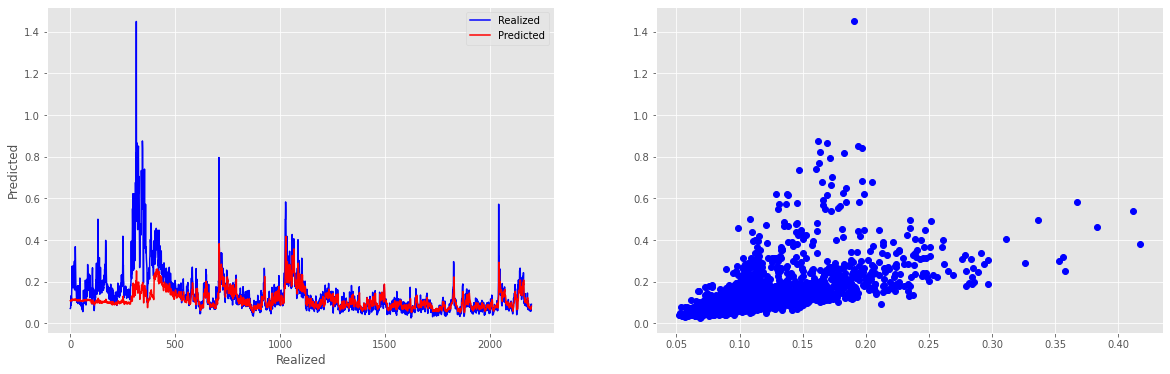

In [209]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].set(xlabel="Points", ylabel="Annualized vol")
ax[0].set(xlabel="Realized", ylabel="Predicted")
ax[0].plot(X_full_4, "b", label="Realized")
ax[0].plot(predstot4, "r", label="Predicted");
ax[1].plot(predstot4, X_full_4, 'bo')
ax[0].legend();

- Nous voyons que rajouter les 3ème vendredi du mois a l'air de rajouter du pouvoir prédictif. Vérifions ca avec la comparaison.

---
# 4 - Comparaison

## RMSE et MAE

In [200]:
def RMSE(y_pred,y):
  return np.sqrt(np.sum((y_pred - y)**2)/len(y_pred))

def MAE(y_pred,y):
  return np.sum(np.abs(y_pred - y))/len(y_pred)

In [210]:
names = ["Rough", "DL seul", "DL + Rough", "DL + Rough_resids", "DL + Rough_resids + IsThirdFriday"]

for name, predict, real in zip(names, [vol_predict, predstot2, predstot3, predstot3_2, predstot4], 
                               [vol_actual, X_full_2, X_full_3, X_full_3_2, X_full_4]):
  rmse = np.round(RMSE(predict, real), 5)
  mae = np.round(MAE(predict, real), 5)
  print(f"{name} : RMSE = {rmse} | MAE = {mae}\n")

Rough : RMSE = 0.04322 | MAE = 0.02574

DL seul : RMSE = 6.5578 | MAE = 212.90069

DL + Rough : RMSE = 6.05404 | MAE = 182.96235

DL + Rough_resids : RMSE = 5.75661 | MAE = 173.50951

DL + Rough_resids + IsThirdFriday : RMSE = 5.64279 | MAE = 162.91572



- Sans surprise le modèle de volatilité rough est le meilleur modèle d'un poin de vie prédiction. 

- Du point de vue Deep Learning, on peut voir que :
  - le LSTM seul a le plus grand taux d'erreur 
  - le LSTM + modèle rough est meilleur
  - faire apprendre des résidus au lieu de la variance prédite diminue le taux d'erreur
  - rajouter le boléen de troisieme vendredi du mois rajoute un pouvoir prédictif.

- Nous vérifions donc qu'utiliser le deep learning en l'aidant de modèles est une des meilleures approches.